In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import numpy as np
import scipy.integrate as sci
import time 
import threading
import sys
import multiprocessing as multiproc
import datetime
# the function library
from projectlib import *
from scipy.optimize import fmin as simplex

## Parameters

In [8]:
class Data:
    def __init__(self, alpha, beta, dimension, name, commuters_day, N):
        "Dimension gives the dimension of the system, i.e. number of cells"
        # ------- TO DO ---------
        # Depending on the system this has to be adjusted
        self.dimension = dimension
        
        "Alpha describes the rate of infection"
        self.alpha = alpha # Dimensions day^(-1)

        "Beta describes the recovery rate"
        self.beta = beta # Dimensions day^(-1)

        "p is the probability to die from the disease"
        self.p = 2.64e-2
        
        """
        Commuters is an array describing the commuters from and to the different cells. 
        The structure is: The entries in column i are how many commute from i to the cell of the row.
                          Thus, the entries of the row i describe how many commute from different cells to cell i.
        """

        self.commuters = np.array([np.ones(self.dimension) for i in range(self.dimension)])
        "load the txt with given name"
        file = np.loadtxt(name, delimiter="\t")
        "fill commuters with the entries from the file. Note the break statement so it doesn't go to far"
        i = 0
        for row in file:
            if i >= self.dimension:
                break
            self.commuters[i] = np.asarray(row[0:self.dimension])
            i += 1
        
        "Part of day that commuters are in other cells. This is the same value for all cells"
        self.commuters_day = commuters_day

        "Array of population in every cell"
        # ------- TO DO ---------
        # figure out how to best do this
        self.N = N

        
        
    def commutersFrom(self, cfrom):
        """Function to extract the commuters from a cell

        Args:
            cfrom (integer): the cell 

         Returns:
            array: array containing commuters from cfrom
        """
        # ------- TO DO ---------
        # optimize the algorithm
        "Sorting out the necessary entries into array a."
        a = np.zeros(self.dimension)
        for i in range(self.dimension):
            a[i] = self.commuters[i][cfrom]
            
        return a 
    
    def commutersTo(self, cto):
        """Function to return an array with number of commuters coming to cto from other cells.

        Args:
            cto (integer): the cell to which the commuters travel

        Returns:
            array: array containing the commuters to cto.
        """
        return self.commuters[cto][:]
       
        
        

## Functions

In [9]:

def function_of_system(timestep, functions,  data, method, t0):
    """Function to calculate the time derivatives of the dynamic SIRD modell with commuters. This function uses multiple approachs for different variant of the system based on prior assumptions. 

        Args:
            functions (array): array with the functions that define the system of equations. Structure [S_1, ... , S_n, I_1, .... , I_n, R_1, ... , R_n, D_1, ... , D_n]
            timestep (float): time of timestep. t=1 is 1 day
            data (class): the class with the relevant data
            method (string): dictates what method is to be used. The choices are "constant", "heaviside"
            t0 (array): array with len = 3 filled with times at which the heaviside functions in the "heaviside" method switch. 
                Note: all values of t0 have to be between 0 and 1.

        Returns:
            array: array containing the derivatives of functions at time t.
    """
    # array with infected
    Infected = functions[data.dimension:2*data.dimension]

    # making array with the effective infected Ieff
    Ieff = np.array([effective_infected(data.commutersTo, data.commutersFrom, data.N, i, Infected, data.dimension) for i in range(data.dimension)])

    # initializing the return array with the time derivatives of functions
    dfuncdt = np.ones(data.dimension*4)

    "~~~~~~~~~~~~~~~~~ See the PDF / LaTeX for further explanation of the equations ~~~~~~~~~~~~~~~~~~~~~~~~"

    # ------------------------------------
    # -      Constant Coefficients       -
    # ------------------------------------

    tt = 0.6

    if method == "constant":
            
        # the for loop to fill dfuncdt

        for i in range(data.dimension):
            # see LaTeX for equations
            # dS/dt
            dfuncdt[i] =  - tt * data.alpha *  functions[i] * functions[i + data.dimension] - (1 - tt) * data.alpha * functions[i] * Ieff[i]

            # dI/dt \propto -dSdt
            dfuncdt[i + data.dimension] = - dfuncdt[i] - data.beta * functions[i + data.dimension]

            # dR/dt
            dfuncdt[i + 2 * data.dimension] = (1 - data.p) * data.beta * functions[i + data.dimension]

            # dD/dt
            dfuncdt[i + 3 * data.dimension] = data.p * data.beta * functions[i + data.dimension]


    # ------------------------------------
    # -      Heaviside Coefficients      -
    # ------------------------------------


    elif method == "heaviside":


        # the for loop to fill dfuncdt
        for i in range(data.dimension):
            # see LaTeX for equations
            # dS/dt
            dfuncdt[i] = - data.alpha * (periodic_heaviside(timestep, t0[0]) + periodic_heaviside(timestep, t0[2]) - 1) * functions[i] * functions[i + data.dimension] - (periodic_heaviside(timestep, t0[1]) - periodic_heaviside(timestep, t0[2])) * data.alpha * functions[i] * Ieff[i]

            # dI/dt \propto -dSdt
            dfuncdt[i + data.dimension] = - dfuncdt[i] - data.beta * functions[i + data.dimension]

            # dR/dt
            dfuncdt[i + 2 * data.dimension] = (1 - data.p) * data.beta * functions[i + data.dimension]

            # dD/dt
            dfuncdt[i + 3 * data.dimension] = data.p * data.beta * functions[i + data.dimension]

    
    
    
    
    
    
    
    # returning the derivatives at time t
    return dfuncdt



# Function for using scipy.integrate.odeint, as the arguments are switched
def system_function(functions, timestep, data, method, t0):
    return function_of_system(timestep, functions, data, method, t0)




In [10]:
p = 0.0264
commuters_day = 10/24

 
dimension = 12
 
a = initial_compartment_distribution(12, "2020/07/24")
initCond = np.zeros(12*4)
for i in range(12):
        initCond[i] = a[i][0]
        initCond[i + 12] = a[i][1]
        initCond[i + 24] = a[i][2]
        initCond[i + 36] = a[i][3]
    
M = region_setup(12)[0]
tzero = np.array([0, 0.4, 0.8])

t = np.linspace(0, 100, 10000)
N = import_rki_data(M, 7)[2]


commuters = np.array([np.ones(dimension) for i in range(dimension)])
"load the txt with given name"
file = np.loadtxt("Pendler.txt", delimiter="\t")
"fill commuters with the entries from the file. Note the break statement so it doesn't go to far"
i = 0
for row in file:
    if i >= dimension:
            break
    commuters[i] = np.asarray(row[0:dimension])
    i += 1

print(N)

[275817.  70458. 136292. 140251. 132285. 326041. 213310. 236764. 202137.
 100629. 100006.  83416.]


## Bewertungsfunktion

In [11]:
def find_sol_on_days_(solt,soly,number_of_days,number_of_Lks):
    S=np.empty((number_of_Lks,number_of_days+1), dtype=float, order='C')
    for k in range(number_of_Lks):
        i=0
        goodtime=0
        for time in range(len(solt)):
            if abs(solt[time]-i)<1e-2:
                goodtime=time
                if time+1 <len(solt):
                    if abs(solt[time+1]-i)<abs(solt[time]-i):
                        goodtime=time+1
                S[k][i]=soly[k][goodtime]
                i=i+1
    return S ## returns S[Landkreis][Tag]

def summon_results(params, method):
    number_of_days=100
    number_of_Lks=12
    dimension = number_of_Lks
    alpha=params[0]
    beta=params[1]
    simulation001 = Data(alpha, beta, dimension, "Pendler.txt", 0.6, import_rki_data(M, 7)[2])
    #sol1 = sci.solve_ivp(fun=function_of_system, t_span=(0, 100), y0=initCond, method="RK45", args=(simulation001, "heaviside", tzero), t_eval=t)
    sol = sci.solve_ivp(fun=function_of_system, t_span=(0, 100), y0=initCond, method="RK45", args=(simulation001, method, tzero), t_eval=t, dense_output=True)
    solt=sol.t
    soly=sol.y
    #print(sol.message)
    ss = find_sol_on_days_(solt,soly,number_of_days,number_of_Lks)
    return ss


def import_RKI_legacy(): # function is redundant and has no use
    number_of_days=100
    number_of_Lks=12
    S=np.empty((number_of_Lks,number_of_days), dtype=float, order='C')
    for d in range(number_of_days):
        curr_date= "2020/07/24"
        curr_date_temp = datetime.datetime.strptime(curr_date, "%Y/%m/%d")
        new_date = curr_date_temp + datetime.timedelta(days=d)
        a = initial_compartment_distribution(number_of_Lks, new_date.strftime("%Y/%m/%d"))
        for k in range(number_of_Lks):
            S[k][d] = a[k][0] 
    return S

#find first day of simulation and import RKI_Inzidenzwert
RKI= np.load("Internal Data/rki_region_cases12.npy") 
begin_of_recording = datetime.datetime.strptime("2020/03/01","%Y/%m/%d")
begin_of_simulation = datetime.datetime.strptime("2020/07/24", "%Y/%m/%d")
d0=(begin_of_simulation-begin_of_recording).days
  

def Inzidenzwert(d,k,is_sim, S):
    # d ist Tag k ist Landkreis
    # die Funktion berechnet Inzidenzwert der Simulation an Tag d in Landkreis k
    if is_sim==0:
        Oomega = RKI[k][2][d0-1+d]
        #print("RKI,",k,d,"  :",Oomega)
        return Oomega
    else:
        if d<7:
            Omega=-(S[k][d]-S[k][0])#*100000
        if d==0:
            Omega=S[k][0]#*100000
        else:
            Omega=-(S[k][d]-S[k][d-7])#*100000
            #print("Sim,",k,d,"  :",Omega)
    return Omega*100000

def IW_DE(d,is_sim, N, S):
    ergebnis=0
    N_ges=0
    for i in range(len(N)):
        ergebnis = ergebnis + N[i]*Inzidenzwert(d,i,is_sim,S)
        N_ges=N_ges+N[i]
    return ergebnis/N_ges
M_ =  region_setup(12)[0]
N_ = import_rki_data(M_, 7)[2]
      

def f(params, method):
    if (params[0]<0):
        return np.inf
    if (params[1]<0):
        return np.inf
    number_of_days = 100
    number_of_Lks = 12
    S = summon_results(params, method)  
    sum0 = 0
    #for d in range(number_of_days):
    #    for k in range(number_of_Lks):
    #        sum0 = sum0 + ((Inzidenzwert(d,k,0,S))-Inzidenzwert(d,k,1, S))**2 / Inzidenzwert(d,k,0,S)
    for d in range(number_of_days):
        sum0 = sum0 +  ( IW_DE(d,0, N_, S) - IW_DE(d,1, N_, S) )**2 / IW_DE(d,0, N_, S)
    return sum0#, len(S[1])


def Bew(params, method, component, which_one):
    if which_one == -1:
        return f(params, method)
    else:
        z=params
        z[which_one] = component
        return f(z, method)

print(summon_results([.4,1/14], 'constant').shape)
for _ in range(1):
    #print(summon_results([.4,1/14])[0][5])
    #print(Inzidenzwert(1,5,0,summon_results([.4,1/14])))
    print(f([.4,1/14], 'constant'))

#Inzidenzwert(d,k,is_sim, S)


(12, 101)
48345693558.977806


## Optimierer 

In [12]:
def isbetter(new_eval, current_eval):
    if new_eval > current_eval:
        return 1
    else:
        return 0
    
def imporve(params, method, component,which_one, sign, evals):

    i = 0
    d = 0
    last_sucess = 0
    new_eval = evals
    value = component
    o_err=2
    if (which_one==-1):
        while i - last_sucess < 15 and o_err < 14:
            if i - last_sucess >8:
                o_err = o_err + 1
                last_sucess = 0
                i = 0
                component = value
            d = i * 10**(-o_err) * sign * np.array(value)
            component = value + d
            evals=new_eval
            new_eval = Bew(params, method, component, which_one)
            i = i + 1
        if new_eval < evals:
            last_sucess=last_sucess + 1
            value=component
            #print(new_eval," ", params)
    i = 0
    d = 0
    last_sucess = 0
    while i - last_sucess < 15 and o_err < 14:
        if i - last_sucess >8:
            o_err = o_err + 1
            last_sucess = 0
            i = 0
            component = value
        d = i * 10**(-o_err) * sign
        component = value + d
        evals=new_eval
        new_eval = Bew(params, method, component, which_one)
        i = i + 1
        if new_eval < evals:
            last_sucess=last_sucess + 1
            value=component
            #print(new_eval," ", params)
    return value, new_eval


def improve_component(params, method, which_one):
    if which_one ==-1:
        component = params
        component_pos, eval1 = imporve(params, method, component,which_one, 1, Bew(params, method, component, which_one))
        component_neg, eval2 = imporve(params, method, component_pos,which_one, -1, eval1)
    else:
        component = params[which_one]
    component_pos, eval1 = imporve(params, method, component,which_one, 1, Bew(params, method, component, which_one))
    component_neg, eval2 = imporve(params, method, component_pos,which_one, -1, eval1)
    if eval1<eval2:
        return component_pos
    else:
        return component_neg

#### Optimierer liefert verbesserte Parameters zurück
def optimize(parameters, method):
    improved_paramters=np.array(parameters)
    for e in range(len(parameters)):
        improved_paramters[e] = improve_component(parameters, method, e)
    return improve_component(parameters, method, -1)



In [10]:
# test for consistancy of Bewertungsfunktion
# what is printed should be equal otherwise optimization does not make any sense
#for _ in range(100):
#    print(f([.4,1/14], method='constant'))
#    print(f([.4,1/14], method='heaviside'))

## run simplex

In [28]:
# Constant commuting

simplex(f,[.4,1/14], args=('constant',), xtol=0.0001, ftol=0.0001, maxiter=None, maxfun=None, full_output=0, disp=1, retall=0, callback=None, initial_simplex=None )
#should print the set of optimal parameters when done

Optimization terminated successfully.
         Current function value: 6696604189.104654
         Iterations: 67
         Function evaluations: 130


array([0.02243358, 0.17376511])

In [29]:
# Heaviside commuting

simplex(f,[.4,1/14], args=('heaviside',), xtol=0.0001, ftol=0.0001, maxiter=None, maxfun=None, full_output=0, disp=1, retall=0, callback=None, initial_simplex=None )
#should print the set of optimal parameters when done

array([0.36965686, 0.07743744])

## run in house optimizer

In [13]:
# Constant commuting

res = optimize([.4,1/14], 'constant')
print("Current function value: ", f(res, 'constant'))
print ("optimale Parameter: ", res)
# prints value of Bewertungsfunktion and used parameters

Current function value:  6696604189.304944
optimale Parameter:  [0.00399975099999999, 0.050374897428571416]


In [14]:
# Heaviside commuting

res = optimize([.4,1/14], 'heaviside')
print("Current function value: ", f(res, 'heaviside'))
print ("optimale Parameter: ", res)
# prints value of Bewertungsfunktion and used parameters

Current function value:  6696604189.582962
optimale Parameter:  [5.931700000003334e-05, 2.982742857130696e-05]


## Plots

In [15]:
resolution = 10

alpha = np.linspace(0,1,resolution)
beta = np.linspace(0,1,resolution)
Z_const = np.zeros((resolution, resolution))
Z_heavi = np.zeros((resolution, resolution))
for i in range(len(alpha)):
    for j in range(len(beta)):
        Z_const[i][j] = f([alpha[i],beta[j]], method='const')
        Z_heavi[i][j] = f([alpha[i],beta[j]], method='heaviside')
        

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

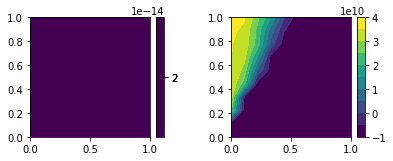

In [18]:
Zdiff_const = Z_const - np.mean(Z_const)
Zdiff_heavi = Z_heavi - np.mean(Z_heavi)

# norm = cm.colors.Normalize(vmax=max(Zdiff_const.max(), Zdiff_heavi.max()), vmin=min(Zdiff_const.min(), Zdiff_heavi.min()))
norm_const = cm.colors.Normalize(vmax=Zdiff_const.max(), vmin=Zdiff_const.min())
norm_heavi = cm.colors.Normalize(vmax=Zdiff_heavi.max(), vmin=Zdiff_heavi.min())
ALPHA, BETA = np.meshgrid(alpha, beta)

# if one colorbar (i.e. corresponding colours) for both plots is wanted:
'''
fig = plt.figure()

grid = AxesGrid(fig, 111,
                nrows_ncols=(1, 2),
                axes_pad=0.25,
               cbar_mode='single',
                cbar_location='right',
                cbar_pad=0.1
                )

cset = grid[0].contourf(
    ALPHA, BETA, Zdiff_const, resolution, norm=norm
    )

cset = grid[1].contourf(
    ALPHA, BETA, Zdiff_heavi, resolution, norm=norm
    )

for ax in grid:
    ax.set_xlim(0, 1)

cbar = ax.cax.colorbar(cset)
cbar = grid.cbar_axes[0].colorbar(cset)
'''

fig, (ax1, ax2) = plt.subplots(1,2)
fig.subplots_adjust(wspace=0.5)

cset1 = ax1.contourf(
    ALPHA, BETA, Zdiff_const, resolution, vmax=Zdiff_const.max(), vmin=Zdiff_const.min()
)
ax1.set(adjustable='box', aspect='equal')
ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("right", size="7%", pad="5%")
cbar1 = fig.colorbar(cset1, cax=cax1)

cset2 = ax2.contourf(
    ALPHA, BETA, Zdiff_heavi, resolution, vmax=Zdiff_heavi.max(), vmin=Zdiff_heavi.min()
)
ax2.set(adjustable='box', aspect='equal')
ax2_divider = make_axes_locatable(ax2)
cax2 = ax2_divider.append_axes("right", size="7%", pad="5%")
cbar2 = fig.colorbar(cset2, cax=cax2)

#ax.set_yscale('log')
#ax.set_xscale('log')
#ax.set_ylim(0, 1)
#ax.set_xticks([])
#ax.set_yticks([])

Zdiff_const

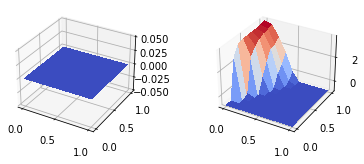

In [19]:
fig, (ax1, ax2) = plt.subplots(1,2, subplot_kw={"projection": "3d"})
fig.subplots_adjust(wspace=0.5)
surf1 = ax1.plot_surface(ALPHA, BETA, Zdiff_const, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
surf2 = ax2.plot_surface(ALPHA, BETA, Zdiff_heavi, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
